# Principal Component Analysis (PCA)

## Περιγραφή Dataset

Χρησιμοποιούμε το **Auto MPG dataset** για classification task:
- **Target:** `origin` (3 κλάσεις: USA, Europe, Japan)
- **Features:** 7 αριθμητικά χαρακτηριστικά
- **Στόχος:** Μείωση διαστάσεων από 7 σε 2 με PCA

---

## 1. Φόρτωση και Προεπεξεργασία Δεδομένων

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = sns.load_dataset('mpg')
print(f"Αρχικό shape: {df.shape}")
df.head()

Αρχικό shape: (398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [3]:
df = df.drop(columns=['name'])
df = df.dropna()
print(f"Μετά καθαρισμό: {df.shape}")

feature_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
X = df[feature_cols].values
y = df['origin'].values

print(f"Features shape: {X.shape}")
print(f"Κλάσεις: {np.unique(y)}")

Μετά καθαρισμό: (392, 8)
Features shape: (392, 7)
Κλάσεις: ['europe' 'japan' 'usa']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

Train: (313, 7), Test: (79, 7)


## 2. Γραφική Αναπαράσταση Δεδομένων

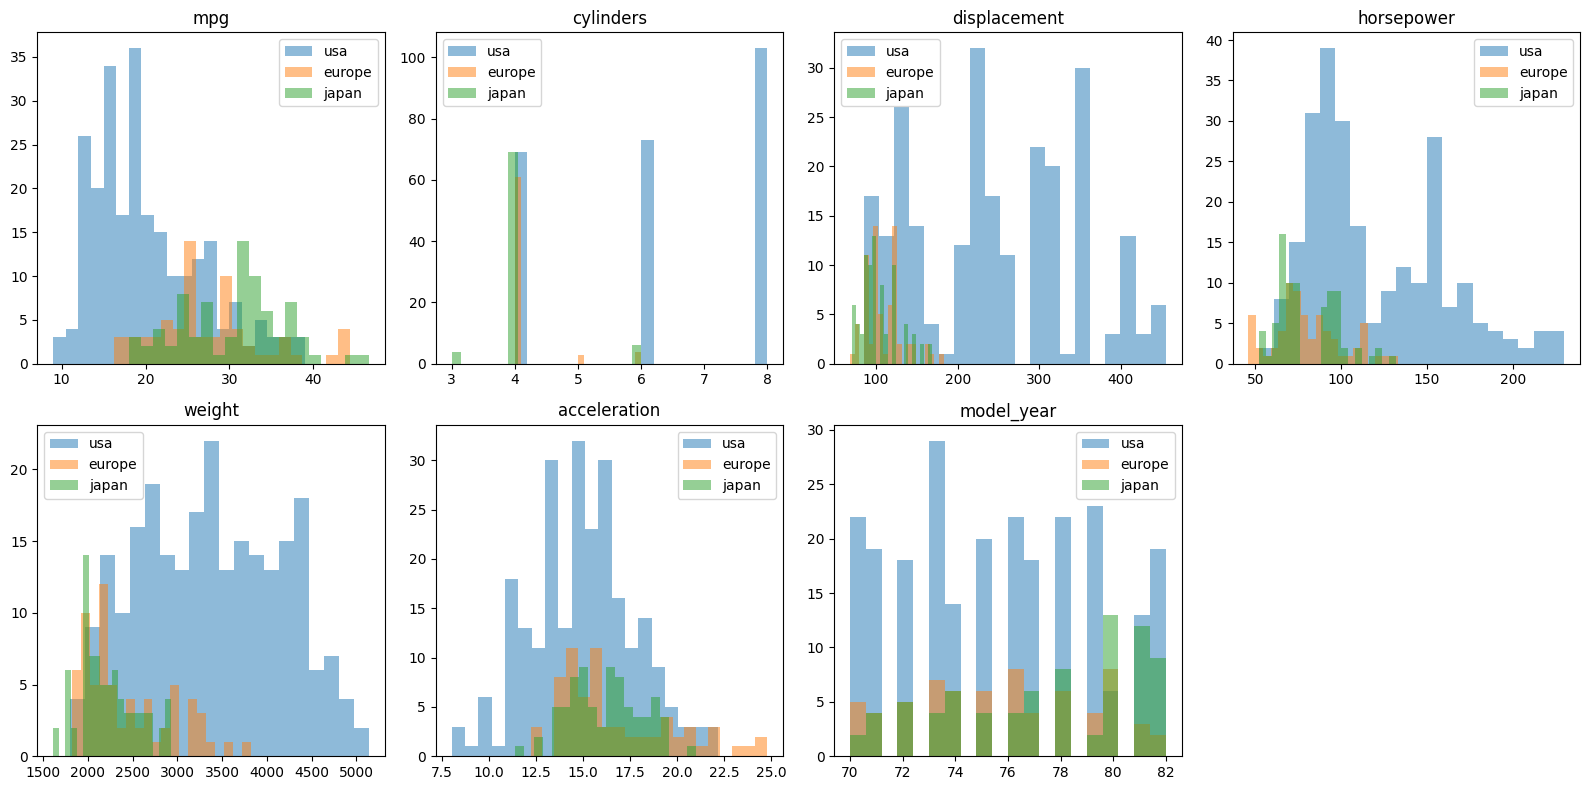

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    for origin in ['usa', 'europe', 'japan']:
        subset = df[df['origin'] == origin][col]
        axes[i].hist(subset, alpha=0.5, label=origin, bins=20)
    axes[i].set_title(col)
    axes[i].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

---

## 3. Manual PCA Implementation

Βήματα:
1. Κεντράρισμα δεδομένων (αφαίρεση μέσου)
2. Υπολογισμός πίνακα συνδιακύμανσης
3. Eigenvalue decomposition
4. Επιλογή κύριων συνιστωσών
5. Προβολή δεδομένων

In [6]:
class ManualPCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.eigenvalues = None
        self.explained_variance_ratio = None
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]
        
        self.eigenvalues = eigenvalues[:self.n_components]
        self.components = eigenvectors[:, :self.n_components]
        self.explained_variance_ratio = self.eigenvalues / np.sum(eigenvalues)
        
        return self
    
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [7]:
manual_pca = ManualPCA(n_components=2)
X_train_pca_manual = manual_pca.fit_transform(X_train_scaled)
X_test_pca_manual = manual_pca.transform(X_test_scaled)

print(f"Αρχικές διαστάσεις: {X_train_scaled.shape[1]}")
print(f"Μειωμένες διαστάσεις: {X_train_pca_manual.shape[1]}")
print(f"\nExplained Variance Ratio:")
print(f"  PC1: {manual_pca.explained_variance_ratio[0]:.4f}")
print(f"  PC2: {manual_pca.explained_variance_ratio[1]:.4f}")
print(f"  Σύνολο: {np.sum(manual_pca.explained_variance_ratio):.4f}")

Αρχικές διαστάσεις: 7
Μειωμένες διαστάσεις: 2

Explained Variance Ratio:
  PC1: 0.7155
  PC2: 0.1244
  Σύνολο: 0.8400


## 4. Scatter Plot - Manual PCA

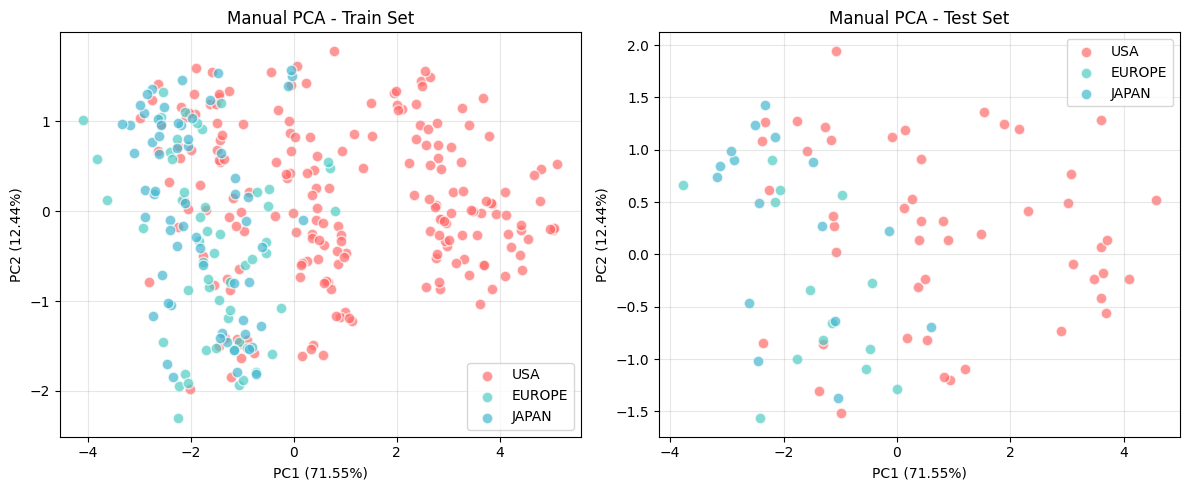

In [8]:
colors = {'usa': '#FF6B6B', 'europe': '#4ECDC4', 'japan': '#45B7D1'}

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for origin in ['usa', 'europe', 'japan']:
    mask = y_train == origin
    plt.scatter(X_train_pca_manual[mask, 0], X_train_pca_manual[mask, 1], 
                c=colors[origin], label=origin.upper(), alpha=0.7, edgecolors='white', s=60)
plt.xlabel(f'PC1 ({manual_pca.explained_variance_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({manual_pca.explained_variance_ratio[1]:.2%})')
plt.title('Manual PCA - Train Set')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for origin in ['usa', 'europe', 'japan']:
    mask = y_test == origin
    plt.scatter(X_test_pca_manual[mask, 0], X_test_pca_manual[mask, 1], 
                c=colors[origin], label=origin.upper(), alpha=0.7, edgecolors='white', s=60)
plt.xlabel(f'PC1 ({manual_pca.explained_variance_ratio[0]:.2%})')
plt.ylabel(f'PC2 ({manual_pca.explained_variance_ratio[1]:.2%})')
plt.title('Manual PCA - Test Set')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. Verification με sklearn PCA

In [9]:
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components=2)
X_train_pca_sklearn = sklearn_pca.fit_transform(X_train_scaled)
X_test_pca_sklearn = sklearn_pca.transform(X_test_scaled)

print("=== Σύγκριση Manual vs sklearn PCA ===")
print(f"\nExplained Variance Ratio:")
print(f"  Manual:  PC1={manual_pca.explained_variance_ratio[0]:.6f}, PC2={manual_pca.explained_variance_ratio[1]:.6f}")
print(f"  sklearn: PC1={sklearn_pca.explained_variance_ratio_[0]:.6f}, PC2={sklearn_pca.explained_variance_ratio_[1]:.6f}")

=== Σύγκριση Manual vs sklearn PCA ===

Explained Variance Ratio:
  Manual:  PC1=0.715529, PC2=0.124426
  sklearn: PC1=0.715529, PC2=0.124426


In [10]:
X_train_pca_sklearn_adjusted = X_train_pca_sklearn.copy()
for i in range(2):
    correlation = np.corrcoef(X_train_pca_manual[:, i], X_train_pca_sklearn[:, i])[0, 1]
    if correlation < 0:
        X_train_pca_sklearn_adjusted[:, i] *= -1

mse = np.mean((X_train_pca_manual - X_train_pca_sklearn_adjusted) ** 2)
print(f"\nMean Squared Error μεταξύ υλοποιήσεων: {mse:.10f}")
print(f"Οι υλοποιήσεις είναι {'πρακτικά ίδιες' if mse < 1e-10 else 'παρόμοιες'}!")


Mean Squared Error μεταξύ υλοποιήσεων: 0.0000000000
Οι υλοποιήσεις είναι πρακτικά ίδιες!


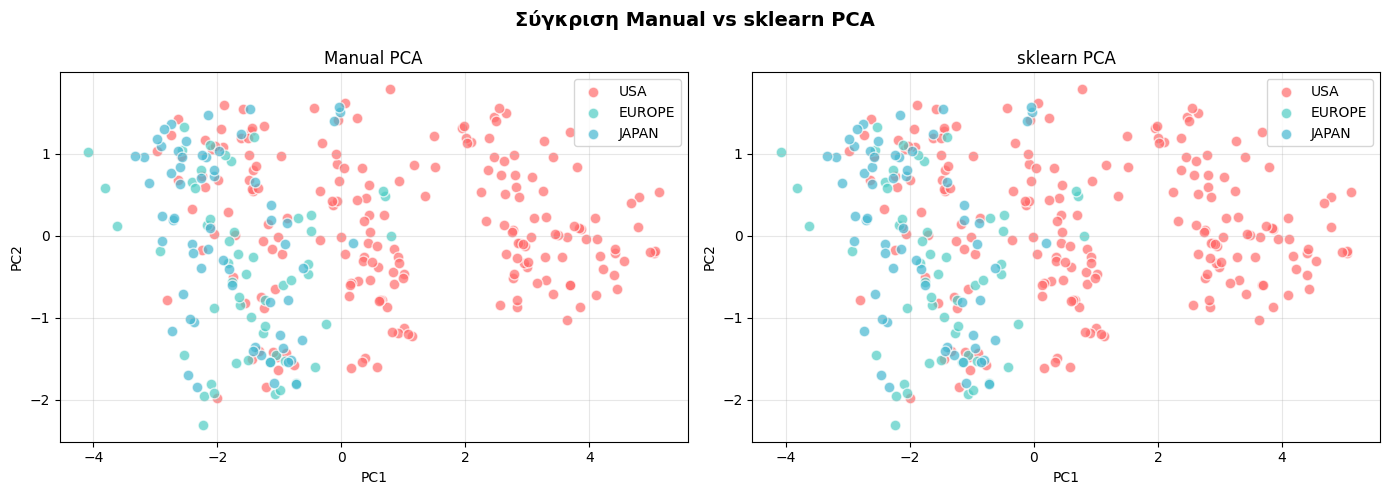

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for origin in ['usa', 'europe', 'japan']:
    mask = y_train == origin
    axes[0].scatter(X_train_pca_manual[mask, 0], X_train_pca_manual[mask, 1], 
                    c=colors[origin], label=origin.upper(), alpha=0.7, edgecolors='white', s=60)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Manual PCA')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for origin in ['usa', 'europe', 'japan']:
    mask = y_train == origin
    axes[1].scatter(X_train_pca_sklearn[mask, 0], X_train_pca_sklearn[mask, 1], 
                    c=colors[origin], label=origin.upper(), alpha=0.7, edgecolors='white', s=60)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title('sklearn PCA')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Σύγκριση Manual vs sklearn PCA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Συμπεράσματα

- Η manual υλοποίηση του PCA παράγει **ταυτόσημα αποτελέσματα** με το sklearn
- Οι 2 πρώτες κύριες συνιστώσες εξηγούν σημαντικό ποσοστό της διακύμανσης
- Το scatter plot δείχνει καλό διαχωρισμό μεταξύ των κλάσεων origin